# Product Recognition on Store Shelves
## Computer Vision and Image Processing - Exam Project
### Nicholas Antonio Carroll, nicholas.carroll@studio.unibo.it - Laura Mazzuca, laura.mazzuca@studio.unibo.it

## Step A: Multiple Product Detection


### Local Invariant Features Paradigm

Allows to successfully identify objects in scene from a 
single model image per object.

**Four steps**:
1. **Detection**: Identify salient repeatable points (Keypoints) in model and scene images.
2. **Description**: Create a unique description of each point, usually based on its local pixel neighborhood.
3. **Matching**: Match point from scene and model according to a similarity function between the descriptors.
4. **Position Estimation**: Estimate the position of the object in the scene image given enough matching points 

### Environment setup

In [33]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  #Connect to google drive folder, needed only if running notebook on colab
  from google.colab import drive
  drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Installs this specific version of opencv as only this one works on colab and lets us use SIFT.

In [34]:
if IN_COLAB:
  !pip install opencv-contrib-python==4.3.0.36

In [35]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

if IN_COLAB:
  scenes_location = 'gdrive/MyDrive/shelf-product-recognition/images/scenes/'
  models_location = 'gdrive/MyDrive/shelf-product-recognition/images/models/'
else:
  scenes_location = 'images/scenes/'
  models_location = 'images/models/'

scenes=['e1.png', 'e2.png', 'e3.png', 'e4.png', 'e5.png']
models=['0.jpg','1.jpg','11.jpg','19.jpg','24.jpg','25.jpg','26.jpg']

for i in range(len(scenes)):
  scenes[i] = scenes_location+scenes[i]

for i in range(len(models)):
  models[i] = models_location+models[i]

Load the train images:

In [36]:
img_train = []
for p in scenes:
    img_train.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) # trainImage

And all the query images:

In [37]:
img_query = []
i=0
max_h = 0
resize = True
for p in models:
    img_query.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) # queryImage
    if resize and max_h < img_query[i].shape[0]:
        max_h = img_query[i].shape[0]
    i=i+1

In [38]:
if resize:
    i=0
    for img in img_query:
        if img.shape[0] < max_h:
            height = int(max_h)
            width = int(img.shape[1]*max_h/img.shape[0])
            dim = (width, height)
            # resize image
            img_query[i] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        i=i+1

### 1. Keypoint Detection
Initialize the SIFT detector object in the following way:


In [39]:
# Initiate SIFT detector
if IN_COLAB:
  sift = cv2.xfeatures2d.SIFT_create(nOctaveLayers=5, contrastThreshold=0.11, sigma=1.4) #very good results with both resized and not resized images
else:
  sift = cv2.SIFT_create(nOctaveLayers=5, contrastThreshold=0.11, sigma=1.4) #very good results with both resized and not resized images


Then we need to find keypoints. We will use _detect_ method of the SIFT detector object. Let us find the keypoints of all the query images:

In [40]:
# find the keypoints and descriptors with SIFT
kp_query = []
for img in img_query:
    kp_query.append(sift.detect(img))

Now, let us find and draw the keypoints for the train images:

In [41]:
kp_train = []
for img in img_train:
    kp_train.append(sift.detect(img))

### 2. Keypoints Description 

Compute for each keypoint a unique description usually based on the nearby pixels (descriptor support).
We will use the SIFT descriptor.

In [42]:
# Describing keypoints for query and train images
des_query = np.empty(len(img_query), dtype=object)
des_train = np.empty(len(img_train), dtype=object)

for i in range(len(img_query)):
    kp_query[i], des_query[i] = sift.compute(img_query[i], kp_query[i])
for i in range(len(img_train)):
    kp_train[i], des_train[i] = sift.compute(img_train[i], kp_train[i])

### 3. Feature Matching

We will use an approximate kd-tree algorithm from **FLANN** (Fast Library for Approximate Nearest Neighbors) included in OpenCV. 

In [43]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 500)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
matches_per_image = np.empty(len(img_train), dtype=object)
i = 0 #index for the train images


for des_t in des_train: #for each scene
    matches_per_image[i] = [] #create a list that will hold the matches wrt each model image
    for des_q in des_query: #for each query image

        matches_per_image[i].append(flann.knnMatch(des_q,des_t,k=2)) #compute the matches
    i = i+1

In [44]:
good = np.empty(len(img_train), dtype=object)
i=0
j=0
for mat_img in matches_per_image:#for each list of matches related to an image wrt a train image
    good[i] = np.empty(len(img_query), dtype=object)
    j=0
    for matches in mat_img: # for each list of matches related to the train image j
        good[i][j] = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good[i][j].append(m)
        j=j+1
    i=i+1

### 4. Position Estimation
We can use  **Random Sample Consensus (RANSAC)**, an algorithm to fit a parametric model to noisy data. In our case estimate an homography from good matches while identifying and discarding the wrong ones.

Since images can have different thresholds to be recognized in a scene, the check_overlap funcion computes the centroid of the bounding box points computed thanks to the homography and if they appear to be overlapping, the one with the most good points gets added to the dst vector, while the other gets removed from it. Then, when a whole scene is scanned, the bounding boxes are finally drawn.

In [45]:
def check_overlap(dst, j):
    if j == 0:
        return -1
    
    control_centroid = dst[j].mean(axis=0)
    print('examining image #{} with centroid = {}'.format(j,control_centroid))
    
    for i in range(j):
        if dst[i] is not None:
            centroid = dst[i].mean(axis=0)
            print('confronting with image #{} with centroid = {}'.format(i,centroid))
            
            difference = np.absolute(centroid-control_centroid)
            if difference[0][0] <= 15.0 and difference[0][1] <=15.0:
                return i
    return -1

In [46]:
# Checking if we found enough matching
img_train_rgb = []
for p in scenes:
    img_train_rgb.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) # trainImage

if resize:
    MIN_MATCH_COUNT = 116 
else:
    MIN_MATCH_COUNT = 80
    
matchesMask = np.empty(len(img_train), dtype=object)
dst = np.empty(len(img_train), dtype=object)
color = (0, 255, 0)

for i in range(len(img_train)):
    cur_kp_train = kp_train[i]
    matchesMask[i] = np.empty(len(img_query), dtype=object)
    dst[i] = np.empty(len(img_query), dtype=object)
    for j in range(len(img_query)):
        if len(good[i][j])>MIN_MATCH_COUNT:
            cur_kp_query = kp_query[j]
            # building the corrspondences arrays of good matches
            src_pts = np.float32([ cur_kp_query[m.queryIdx].pt for m in good[i][j] ]).reshape(-1,1,2)
            dst_pts = np.float32([ cur_kp_train[m.trainIdx].pt for m in good[i][j] ]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Mask of discarded point used in visualization
            matchesMask[i][j] = mask.ravel().tolist()
            # Corners of the query image
            h,w = img_query[j].shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst[i][j] = cv2.perspectiveTransform(pts,M)
            
            overlap_idx = check_overlap(dst[i], j)
            if overlap_idx > -1:
                if len(good[i][j]) >= len(good[i][overlap_idx]):
                    dst[i][overlap_idx] = None
                else:
                    dst[i][j] = None         
        else:
            print( "Not enough matches are found - {}/{}".format(len(good[i][j]), MIN_MATCH_COUNT) )
            matchesMask[i][j] = None
            
    for j in range(len(img_query)):
        if dst[i][j] is not None:
            print('drawing on scene #{} bounding box #{}'.format(i,j))
            # Drawing the bounding box
            img_train_rgb[i] = cv2.polylines(img_train_rgb[i],[np.int32(dst[i][j])],True,color,3, cv2.LINE_AA)


examining image #1 with centroid = [[444.92523 166.20421]]
confronting with image #0 with centroid = [[163.05396 214.79985]]
examining image #2 with centroid = [[443.5797  169.07445]]
confronting with image #0 with centroid = [[163.05396 214.79985]]
confronting with image #1 with centroid = [[444.92523 166.20421]]
Not enough matches are found - 31/116
Not enough matches are found - 49/116
Not enough matches are found - 16/116
Not enough matches are found - 116/116
drawing on scene #0 bounding box #0
drawing on scene #0 bounding box #2
Not enough matches are found - 68/116
Not enough matches are found - 43/116
Not enough matches are found - 13/116
Not enough matches are found - 24/116
examining image #4 with centroid = [[168.1521  221.23907]]
examining image #5 with centroid = [[878.74054 234.80424]]
confronting with image #4 with centroid = [[168.1521  221.23907]]
examining image #6 with centroid = [[538.4021  218.51569]]
confronting with image #4 with centroid = [[168.1521  221.23907]

Finally, if we want to draw the matches we can do it in the following way:

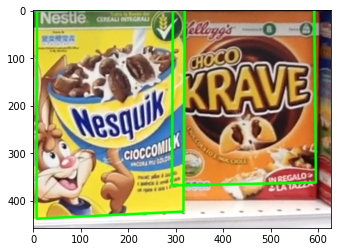

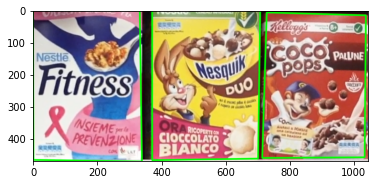

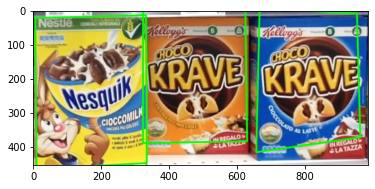

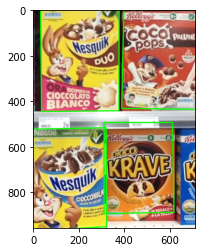

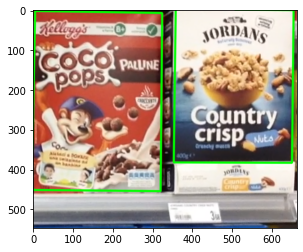

In [47]:
for img in img_train_rgb:
    plt.imshow(img)
    plt.show()

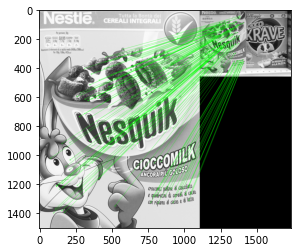

232


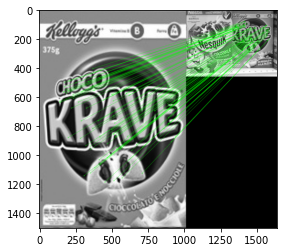

174


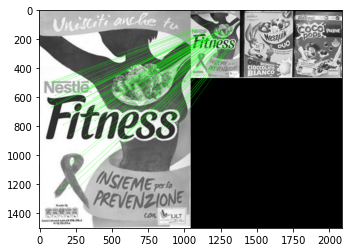

119


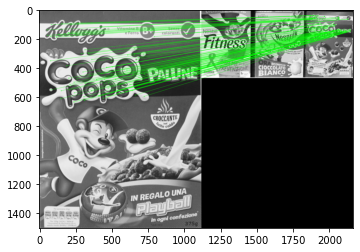

162


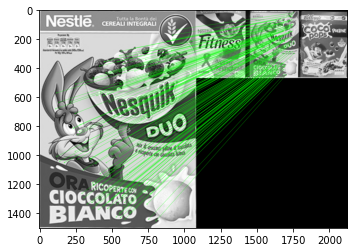

248


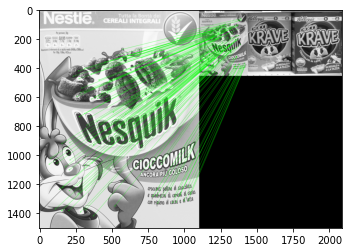

188


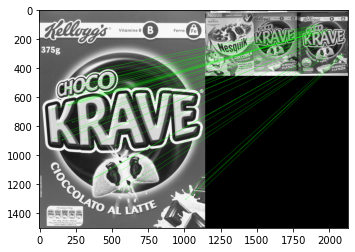

133


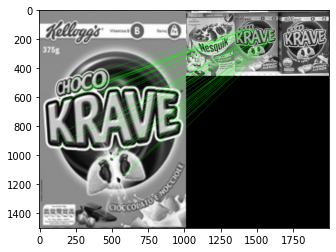

118


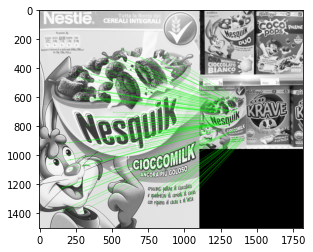

170


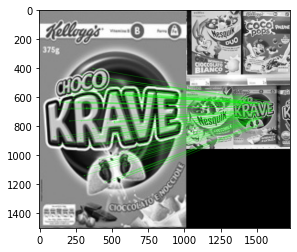

145


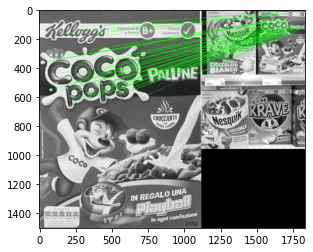

146


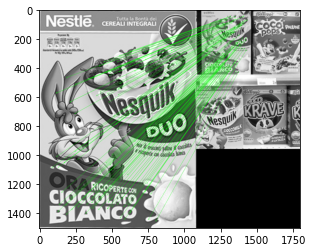

176


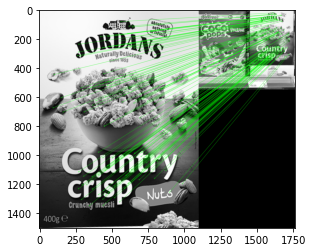

141


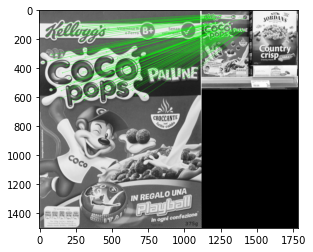

164


In [48]:
# Drawing the matches
for i in range(len(img_train)):
    for j in range(len(img_query)):
        if dst[i][j] is not None:
            draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask[i][j], # draw only inliers
                   flags = 2) # not draw keypoints only lines
            img3 = cv2.drawMatches(img_query[j],kp_query[j],img_train[i],kp_train[i],good[i][j],None,**draw_params)
            plt.imshow(img3, 'gray')
            plt.show()
            print(len(good[i][j]))